In [308]:
%load_ext autoreload
%autoreload 2
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
dr2period=22/12 # in years
edr3Period=34/12 # in years

119.35355168784646 -39.57891898406973 8.46203313133002 -3.6336899666465228 4.468863118935975


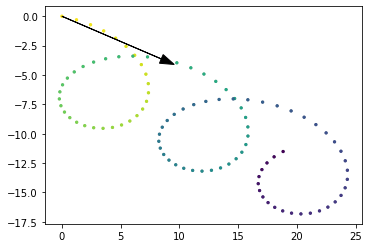

In [335]:
ra=360*np.random.rand()
dec=90*(-1+2*np.random.rand())
pmra=10*np.random.randn()
pmdec=10*np.random.randn()
pllx=10*np.random.rand()
params=astromet.params()
params.RA=ra
params.Dec=dec
params.pmRA=pmra
params.pmDec=pmdec
params.pllx=pllx
ts=np.sort((34/12)*np.random.rand(128))
ts=np.linspace(0,edr3Period,100)
print(ra,dec,pmra,pmdec,pllx)
ras,decs=astromet.path(ts,params)
params.M=5
params.q=0.1
params.l=0.1
bras,bdecs=astromet.path(ts,params)


dRas=(ras-ra)/astromet.mas
dDecs=(decs-dec)/astromet.mas
bdRas=(bras-ra)/astromet.mas
bdDecs=(bdecs-dec)/astromet.mas

qPl=plt.gca()
timeCmap=mpl.cm.get_cmap('cividis_r')
binaryCmap=mpl.cm.get_cmap('viridis_r')
qPl.scatter(dRas,dDecs,s=5,c=timeCmap(ts/ts[-1]),alpha=0.5)
qPl.scatter(bdRas,bdDecs,s=5,c=binaryCmap(ts/ts[-1]))
qPl.arrow(0,0,pmra,pmdec,head_width=0.8,color='k')
qPl.set_aspect('equal')
plt.show()

In [336]:
params,error=astromet.fit(ts,ras,decs)
print(ra,dec,pmra,pmdec,pllx)
print(params)
#print(params/astromet.mas)
#print('ra diff (mas): ',(params[0]-ra)/astromet.mas)
#print('dec diff (mas): ',(params[1]-dec)/astromet.mas)
print(np.diagonal(np.sqrt(error)/astromet.mas))

medRa:  119.35355168784646
119.35355168784646 -39.57891898406973 8.46203313133002 -3.6336899666465228 4.468863118935975
[-2.44442384e-09  6.59695160e-10  8.46203313e+00 -3.63368997e+00
  4.46886312e+00]
[0.20010549 0.21209622 0.12336673 0.12118371 0.09225437]


/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [307]:
print(len(np.ones(10)))

10


In [298]:
coord=astropy.coordinates.SkyCoord(ra=10.625*u.degree, dec=0*u.degree, pm_ra_cosdec=2*u.mas/u.yr, pm_dec=2*u.mas/u.yr, frame='icrs')

In [252]:
ts=2456863.94+np.linspace(0,100,8)
print(astropy.time.Time(ts,format='jd'))
pos=astropy.coordinates.get_body_barycentric('earth', astropy.time.Time(ts,format='jd'))
print(pos)
print(pos[0])
stack=np.vstack([pos.x.value,pos.y.value,pos.z.value]).T
print(stack)
print(stack.shape)

[2456863.94       2456878.22571429 2456892.51142857 2456906.79714286
 2456921.08285714 2456935.36857143 2456949.65428571 2456963.94      ]
[(0.5437321 , -0.78983095, -0.34253217),
 (0.73020287, -0.64882719, -0.2814133 ),
 (0.87472074, -0.47060279, -0.20414676),
 (0.96846754, -0.26501996, -0.11503166),
 (1.00558845, -0.04407469, -0.0192449 ),
 (0.98309622,  0.17947244,  0.07765889),
 (0.90181995,  0.39207747,  0.16982962),
 (0.76578746,  0.58081888,  0.25164612)] AU
(0.5437321, -0.78983095, -0.34253217) AU
[[ 0.5437321  -0.78983095 -0.34253217]
 [ 0.73020287 -0.64882719 -0.2814133 ]
 [ 0.87472074 -0.47060279 -0.20414676]
 [ 0.96846754 -0.26501996 -0.11503166]
 [ 1.00558845 -0.04407469 -0.0192449 ]
 [ 0.98309622  0.17947244  0.07765889]
 [ 0.90181995  0.39207747  0.16982962]
 [ 0.76578746  0.58081888  0.25164612]]
(8, 3)


In [139]:
print(coord.barycentrictrueecliptic)
print(coord.barycentrictrueecliptic.lon.degree)
lat=coord.barycentrictrueecliptic.lat.degree
print(coord.barycentrictrueecliptic.pm_lon_coslat.value/np.cos(np.pi*lat/180))
print(coord.barycentrictrueecliptic.pm_lat.value)
print(np.sqrt((coord.barycentrictrueecliptic.pm_lon_coslat.value/np.cos(np.pi*lat/180))**2+coord.barycentrictrueecliptic.pm_lat.value++2))
print(np.sqrt(8))

<SkyCoord (BarycentricTrueEcliptic: equinox=J2000.000): (lon, lat) in deg
    (9.76187984, -4.20625309)
 (pm_lon_coslat, pm_lat) in mas / yr
    (2.62397437, 1.05582126)>
9.761879842812618
2.631061186369181
1.0558212570902263
3.1588453940496404
2.8284271247461903


In [37]:
coord=astropy.coordinates.SkyCoord(lon=10.625*u.degree, lat=0*u.degree, frame='barycentrictrueecliptic')

In [39]:
print(coord.icrs)

<SkyCoord (ICRS): (ra, dec) in deg
    (9.76931376, 4.20776907)>
